# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
import scripts.data_dictionary as dd
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 1

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 11:15,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7
1,4/11/2018 11:30,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8
2,4/11/2018 11:45,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9
3,4/11/2018 12:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8
4,4/11/2018 12:15,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19484.000000,19484.000000,19484.000000,19484.000000,19484.000000,19484.000000,19484.000000,19484.000000
mean,18.811541,2105.587354,-136.048199,8.752403,69.619871,87.104491,8.094141,1.681426
std,5.116165,168.535267,12.108105,0.207511,66.298007,13.022364,1.136476,1.547929
min,7.550000,2.000000,-176.400000,8.390000,0.000000,62.800000,5.140000,-0.400000
25%,15.260000,1961.000000,-145.800000,8.600000,37.500000,79.400000,7.300000,0.700000
50%,19.910000,2145.000000,-131.700000,8.690000,52.935000,83.400000,7.880000,1.200000
75%,22.750000,2237.000000,-127.600000,8.930000,79.022500,91.200000,8.770000,2.100000
max,28.220000,2389.000000,-113.800000,9.450000,2273.070000,191.300000,15.340000,28.300000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 11:15:00,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8,2018-04-11 11:30:00
2018-04-11 11:45:00,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9,2018-04-11 11:45:00
2018-04-11 12:00:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8,2018-04-11 12:00:00
2018-04-11 12:15:00,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8,2018-04-11 12:15:00


## Import And Clean Weather Data

In [10]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [12]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [13]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [14]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [15]:
# Test some date comparison logic
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][0])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][0])
print()
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][4])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][4])


2017-05-05
2017-05-01
False

2017-05-05
2017-05-05
True


In [16]:
# Test some indexing logic
weather[weather['DATE'] == train_dfs[train_index]['datetime'][2].date()]['PRCP'].values[0]

0.0

In [17]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Verify weather values copied over correctly

In [18]:
train_dfs[train_index].head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:15:00,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,2017-05-05 01:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:30:00,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,2017-05-05 01:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:45:00,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,2017-05-05 01:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 02:00:00,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,2017-05-05 02:00:00,0.0,0.0,0.0,31.7,8.9


In [19]:
weather.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,
2017-05-01,2017-05-01,0.0,0.0,0.0,18.9,7.2
2017-05-02,2017-05-02,0.0,0.0,0.0,19.4,7.8
2017-05-03,2017-05-03,0.0,0.0,0.0,21.7,4.4
2017-05-04,2017-05-04,0.0,0.0,0.0,26.7,6.7
2017-05-05,2017-05-05,0.0,0.0,0.0,31.7,8.9
2017-05-06,2017-05-06,1.8,0.0,0.0,30.6,15.0
2017-05-07,2017-05-07,0.0,0.0,0.0,27.2,18.9
2017-05-08,2017-05-08,0.0,0.0,0.0,25.6,12.2
2017-05-09,2017-05-09,0.0,0.0,0.0,25.6,9.4


### Import and Clean Wind Data

In [20]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [21]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                # there is a scaling factor involved in the ground station data reading
                reading.WO_wind_speed = int(reading.WO_wind_speed)/10.0
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [22]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [23]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,2.6
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,2.6


In [24]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 11:15:00,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:45:00,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9,2018-04-11 11:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 12:00:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8,2018-04-11 12:00:00,0.0,0.0,0.0,25.0,10.0,120.0,3.6
2018-04-11 12:15:00,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8,2018-04-11 12:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [25]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [26]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,2.6
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,2.6
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,2.6
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,2.6
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,2.6


In [27]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 11:15:00,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,120.000,3.6
2018-04-11 11:30:00,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,120.000,3.6
2018-04-11 11:45:00,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9,2018-04-11 11:45:00,0.0,0.0,0.0,25.0,10.0,120.000,3.6
2018-04-11 12:00:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8,2018-04-11 12:00:00,0.0,0.0,0.0,25.0,10.0,120.000,3.6
2018-04-11 12:15:00,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8,2018-04-11 12:15:00,0.0,0.0,0.0,25.0,10.0,130.625,2.7


In [28]:
print(np.sum(test_dfs[test_index].isna()))

print(np.sum(train_dfs[train_index].isna()))

Temp C                   0
Sp Cond (uS/cm)          0
pH (mV)                  0
pH                       0
Turbidity (NTU)          0
ODOSat%                  0
ODO (mg/L)               0
BGA-Phycocyanin RFU      0
datetime                 0
PRCP                   480
SNOW                   288
SNWD                   288
TMAX                     0
TMIN                     0
Wind Angle               0
Wind Speed               0
dtype: int64
Temp C                 0
Sp Cond (uS/cm)        0
pH (mV)                0
pH                     0
Turbidity (NTU)        0
ODOSat%                0
ODO (mg/L)             0
BGA-Phycocyanin RFU    0
datetime               0
PRCP                   0
SNOW                   0
SNWD                   0
TMAX                   0
TMIN                   0
Wind Angle             0
Wind Speed             0
dtype: int64


In [29]:
start = test_dfs[test_index]['datetime'][0].date()
end = test_dfs[test_index]['datetime'][60].date()
weather[start:end]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,
2018-04-11,2018-04-11,0.0,0.0,0.0,25.0,10.0
2018-04-12,2018-04-12,1.8,0.0,0.0,21.7,3.3


In [30]:
# This is a proof of concempt to see if it would be working
dat_frm = pd.DataFrame({'temp':[2,4,6,8,10,20,50,45],'tempo':[2,4,6,8,10,20,50,45]})
test ={'var1': lambda x:"first" if x <= 10 else None,
       'var2': lambda x:"second" if x <= 20 and x > 10 else None,
       'var3': lambda x:"third" if x > 20 else None,
        }

def do_the_dic(x, dic):
    ret_val = None
    for key in dic.keys():
        ret_val = dic[key](x)
        if ret_val is not None:
            return ret_val

    
def bucket_column(df, column, dictionary):
    """
    :param df: the dataframe to bucket
    :param column: the column of the dataframe to bucket
    :param dictionary: the dictionary with the conditionals within. all conditions met to garontee the working as intended
    
    :return: the altered dataframe with a new colum of column (passed in) + '_bucket' as a category type
    """
    df[column + '_bucket'] = df[column].apply(do_the_dic, args=(dictionary,)).astype('category')

bucket_column(dat_frm,'temp',test)

## Weather Investigation

In [31]:
df = train_dfs[train_index].drop(columns=['datetime'])
df.describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.0,18947.0,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511,0.527450,0.0,0.0,27.982852,11.708170,203.031087,3.035744
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423,2.446299,0.0,0.0,8.039940,6.272027,82.070747,2.224318
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000,0.000000,0.0,0.0,6.100000,-3.900000,10.000000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000,0.000000,0.0,0.0,21.100000,6.100000,137.500000,1.650000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000,0.000000,0.0,0.0,30.600000,13.300000,190.000000,2.600000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000,0.000000,0.0,0.0,35.000000,17.200000,273.750000,3.825000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000,23.400000,0.0,0.0,40.000000,22.200000,360.000000,18.000000


In [32]:
#Scale the date for easy chart comparisons
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


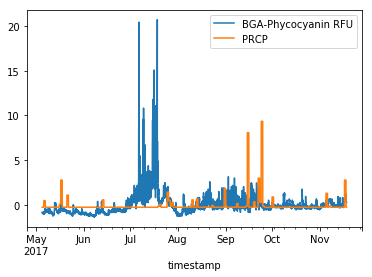

In [33]:
df[[target_column, 'PRCP']].plot.line()

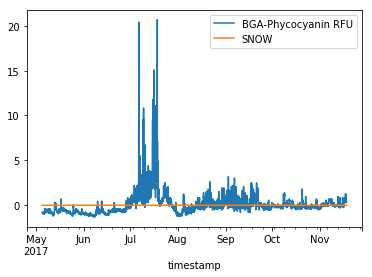

In [34]:
df[[target_column, 'SNOW']].plot.line()

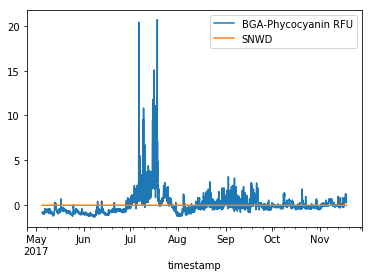

In [35]:
df[[target_column, 'SNWD']].plot.line()

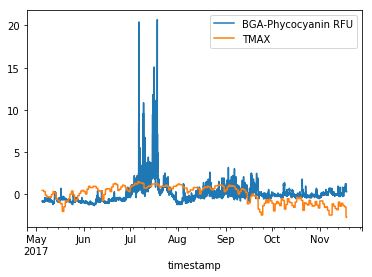

In [36]:
df[[target_column, 'TMAX']].plot.line()

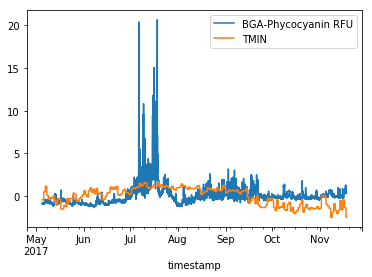

In [37]:
df[[target_column, 'TMIN']].plot.line()

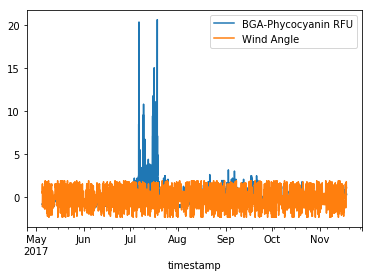

In [38]:
df[[target_column,'Wind Angle']].plot.line()

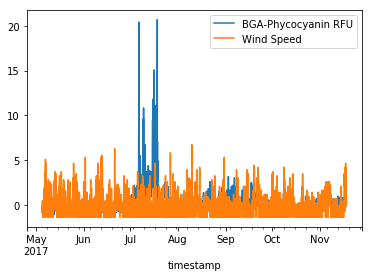

In [39]:
df[[target_column,'Wind Speed']].plot.line()

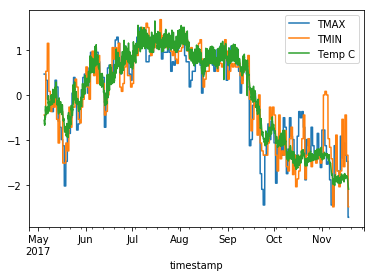

In [40]:
df[['TMAX', 'TMIN', 'Temp C']].plot.line()

As expected, we won't get any additional signal from air temperature measurements since they correlate to water temperature. And since the area has so little rain, rain will most likely not provide a decent signal either

## Extract Windows

In [41]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [42]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [43]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## Add Weather Categories

In [44]:
weather_columns = ['Wind Speed','Wind Angle','PRCP','SNOW','SNWD','TMAX','TMIN']
x_columns = weather_columns + x_columns + ['Wind Speed_bucket','Wind Angle_bucket','PRCP_bucket','SNOW_bucket','SNWD_bucket','TMAX_bucket','TMIN_bucket']

In [45]:
for df in test_dfs + train_dfs:
    for column in weather_columns:
        bucket_column(df, column, dd.all_dic[column])

In [46]:
#Check to seee if the buckets worked
train_dfs[train_index].head()

,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,PRCP,SNOW,SNWD,Sp Cond (uS/cm),TMAX,TMIN,Temp C,...,datetime,pH,pH (mV),Wind Speed_bucket,Wind Angle_bucket,PRCP_bucket,SNOW_bucket,SNWD_bucket,TMAX_bucket,TMIN_bucket
datetimeIndex,,,,,,,,,,,,,,,,,,,,,
2017-05-06 21:36:00,0.625,9.608,97.64,1.8,0.0,0.0,1901.2,31.7,15.0,16.57,...,2017-05-06 21:36:00,8.4,-99.70,Fresh Breeze,WNW,Light,None,None,Hot,Moderate
2017-05-06 22:36:00,0.625,9.608,97.64,1.8,0.0,0.0,1910.4,31.7,15.0,16.57,...,2017-05-06 22:36:00,8.4,-99.60,Fresh Breeze,WNW,Light,None,None,Hot,Moderate
2017-05-06 23:36:00,0.625,9.608,97.64,1.8,0.0,0.0,1914.0,31.7,15.0,16.57,...,2017-05-06 23:36:00,8.4,-99.50,Fresh Breeze,WNW,Light,None,None,Hot,Moderate
2017-05-07 00:36:00,0.625,9.608,97.64,1.8,0.0,0.0,1914.0,31.7,18.9,16.57,...,2017-05-07 00:36:00,8.4,-99.40,Fresh Breeze,WNW,Light,None,None,Hot,Room
2017-05-07 01:36:00,0.625,9.608,97.64,1.8,0.0,0.0,1915.0,31.7,18.9,16.57,...,2017-05-07 01:36:00,8.4,-99.36,Fresh Breeze,W,Light,None,None,Hot,Room


### box plot all the things

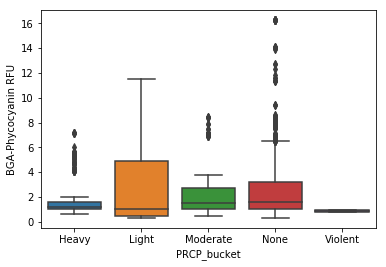

In [47]:
sns.boxplot(data=test_dfs[test_index], x='PRCP_bucket', y=target_column)

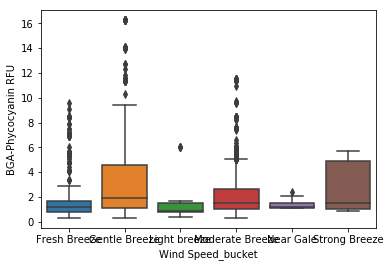

In [48]:
sns.boxplot(data=test_dfs[test_index], x='Wind Speed_bucket', y=target_column)

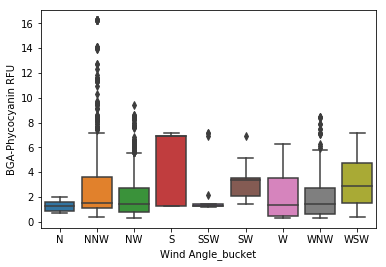

In [49]:
sns.boxplot(data=test_dfs[test_index], x='Wind Angle_bucket', y=target_column)

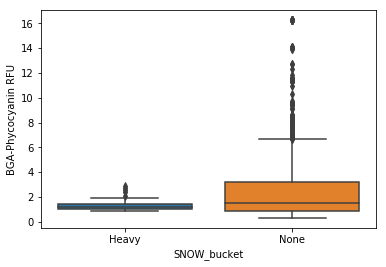

In [50]:
sns.boxplot(data=test_dfs[test_index], x='SNOW_bucket', y=target_column)

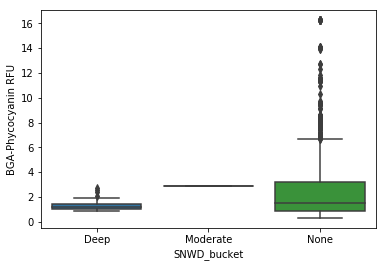

In [51]:
sns.boxplot(data=test_dfs[test_index], x='SNWD_bucket', y=target_column)

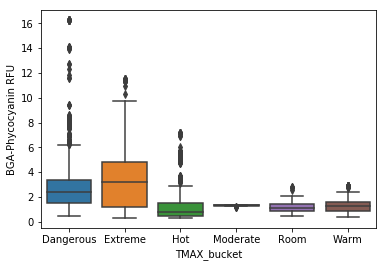

In [52]:
sns.boxplot(data=test_dfs[test_index], x='TMAX_bucket', y=target_column)

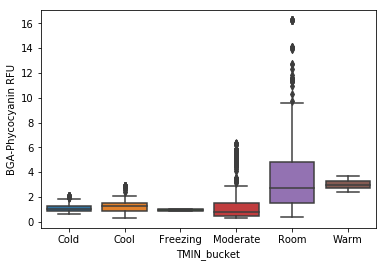

In [53]:
sns.boxplot(data=test_dfs[test_index], x='TMIN_bucket', y=target_column)

## BGA RFU Levels

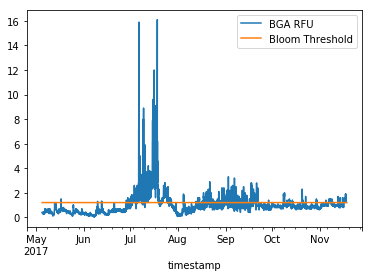

In [54]:
presegmented_plot.plot.line()

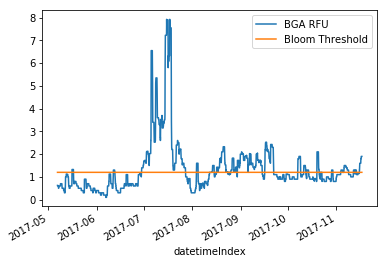

In [55]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

In [56]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

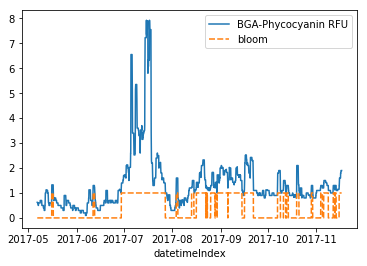

In [57]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

## Logistic Regression Model

In [58]:
print(test_dfs[test_index].columns)
print(train_dfs[train_index].columns)
print(x_columns)

Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)',
       'Wind Speed_bucket', 'Wind Angle_bucket', 'PRCP_bucket', 'SNOW_bucket',
       'SNWD_bucket', 'TMAX_bucket', 'TMIN_bucket', 'bloom'],
      dtype='object')
Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)',
       'Wind Speed_bucket', 'Wind Angle_bucket', 'PRCP_bucket', 'SNOW_bucket',
       'SNWD_bucket', 'TMAX_bucket', 'TMIN_bucket', 'bloom'],
      dtype='object')
['Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed_bucket', 'Wind Angle_bucket', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket', 

### Null Model

In [66]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)',
       'Wind Speed_bucket', 'Wind Angle_bucket', 'PRCP_bucket', 'SNOW_bucket',
       'SNWD_bucket', 'TMAX_bucket', 'TMIN_bucket', 'bloom'],
      dtype='object')


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [67]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.6499270681391957
Recall: 0.9383171304056319
Precision 0.6516880093131548
Confusion Matrix:
 [[ 320 1496]
 [ 184 2799]]
columns: ['Wind Speed', 'Wind Angle', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed_bucket', 'Wind Angle_bucket', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket', 'TMAX_bucket', 'TMIN_bucket']


### Greedy Model

In [68]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Wind Speed
Accuracy 0.4457178578870598
Recall: 0.2380154207173986
Precision 0.6472196900638104
Confusion Matrix:
 [[1429  387]
 [2273  710]]

Training model with: Wind Angle
Accuracy 0.4400916857678683
Recall: 0.1806905799530674
Precision 0.6892583120204604
Confusion Matrix:
 [[1573  243]
 [2444  539]]

Training model with: PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNOW


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNWD


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: TMAX
Accuracy 0.5865805376120025
Recall: 0.45759302715387196
Precision 0.7885615251299827
Confusion Matrix:
 [[1450  366]
 [1618 1365]]

Training model with: TMIN
Accuracy 0.6686809752031673
Recall: 0.5306738183037211
Precision 0.8928369994359842
Confusion Matrix:
 [[1626  190]
 [1400 1583]]

Training model with: Temp C
Accuracy 0.6072098353823713
Recall: 0.39088166275561514
Precision 0.9448946515397083
Confusion Matrix:
 [[1748   68]
 [1817 1166]]

Training model with: Sp Cond (uS/cm)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: pH (mV)
Accuracy 0.6228380912690143
Recall: 0.9963124371438149
Precision 0.6229302033116747
Confusion Matrix:
 [[  17 1799]
 [  11 2972]]

Training model with: pH
Accuracy 0.7589081058553865
Recall: 0.6895742541066041
Precision 0.8990384615384616
Confusion Matrix:
 [[1585  231]
 [ 926 2057]]

Training model with: Turbidity (NTU)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: ODOSat%
Accuracy 0.6799333194415503
Recall: 0.5095541401273885
Precision 0.9541745134965474
Confusion Matrix:
 [[1743   73]
 [1463 1520]]

Training model with: ODO (mg/L)
Accuracy 0.5788705980412586
Recall: 0.36808581964465303
Precision 0.8897893030794165
Confusion Matrix:
 [[1680  136]
 [1885 1098]]

Training model with: Wind Speed_bucket
Accuracy 0.5317774536361742
Recall: 0.4294334562520952
Precision 0.7015334063526835
Confusion Matrix:
 [[1271  545]
 [1702 1281]]

Training model with: Wind Angle_bucket
Accuracy 0.4102938112106689
Recall: 0.11800201139792156
Precision 0.6388384754990926
Confusion Matrix:
 [[1617  199]
 [2631  352]]

Training model with: PRCP_bucket


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNOW_bucket


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNWD_bucket


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: TMAX_bucket
Accuracy 0.4836424255053136
Recall: 0.5598390881662756
Precision 0.5890652557319224
Confusion Matrix:
 [[ 651 1165]
 [1313 1670]]

Training model with: TMIN_bucket
Accuracy 0.6232548447593249
Recall: 0.8069057995306739
Precision 0.6614454520472657
Confusion Matrix:
 [[ 584 1232]
 [ 576 2407]]

pH metric value: 0.7589081058553865
ODOSat% metric value: 0.6799333194415503
TMIN metric value: 0.6686809752031673
TMIN_bucket metric value: 0.6232548447593249
pH (mV) metric value: 0.6228380912690143
Temp C metric value: 0.6072098353823713
TMAX metric value: 0.5865805376120025
ODO (mg/L) metric value: 0.5788705980412586
Wind Speed_bucket metric value: 0.5317774536361742
TMAX_bucket metric value: 0.4836424255053136
Wind Speed metric value: 0.4457178578870598
Wind Angle metric value: 0.4400916857678683
Wind Angle_bucket metric value: 0.4102938112106689
PRCP metric 

In [69]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMIN_bucket', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Wind Speed_bucket', 'TMAX_bucket', 'Wind Speed', 'Wind Angle', 'Wind Angle_bucket', 'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMIN_bucket', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Wind Speed_bucket', 'TMAX_bucket', 'Wind Speed', 'Wind Angle', 'Wind Angle_bucket', 'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket']
Training model with: ['pH']
Test model accuracy: 0.7589081058553865
Test model recall: 0.6895742541066041
Test model precision: 0.8990384615384616

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7884976036674307
Test model recall: 0.7006369426751592
Test model precision: 0.9448462929475587

Updating greedy model

Training model with: ['pH', 'ODOSat

Model AUC: 0.9009


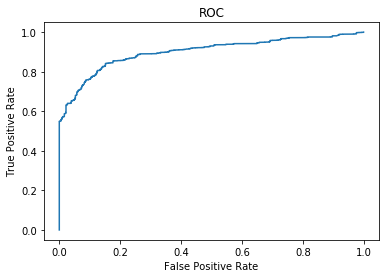

In [70]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Random Forest Model

In [71]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.726401333611169
Recall: 0.685886691250419
Precision 0.8447563996696945
Confusion Matrix:
 [[1440  376]
 [ 937 2046]]


In [72]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMIN_bucket', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Wind Speed_bucket', 'TMAX_bucket', 'Wind Speed', 'Wind Angle', 'Wind Angle_bucket', 'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'TMIN_bucket', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Wind Speed_bucket', 'TMAX_bucket', 'Wind Speed', 'Wind Angle', 'Wind Angle_bucket', 'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP_bucket', 'SNOW_bucket', 'SNWD_bucket']
Training model with: ['pH']
Test model accuracy: 0.7634923942488019
Test model recall: 0.7220918538384177
Test model precision: 0.875609756097561

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.6445092727651595
Test model recall: 0.5320147502514248
Test model precision: 0.8365840801265155

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.

Model AUC: 0.8767


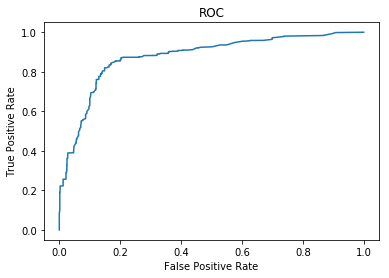

In [73]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)